# **Use CASCADE to infer spiking activity for your own data**
---

This is a demo script for the inference of spiking activity from calcium imaging data. It is based on the Github repository https://github.com/HelmchenLabSoftware/Cascade. On the repository, you can also find a link to a demo script that runs on the cloud (Colaboratory Notebook) without need to install anything locally.

In this notebook:

The function **load_neurons_x_time()** loads the input data as a matrix. It can
be modified by the user to load npy-files, mat-files or any other standard format.

After loading the dF/F data, some example traces are plotted.
    
The line **spike_prob = cascade.predict( model_name, traces )** performs the
predictions. As input, it uses the loaded calcium recordings ('traces') and
the pretrained model ('model_name'). To train a new model (usually not necessary), check out the companion Jupyter notebook.    
    
The output is a matrix with the inferred spike rates.
    
---

## 1. Import python packages

Imports standard python packages, and the main CASCADE packages (cascade2p).

If the message of a ModuleNotFoundError appears, double check if you have selected the correct kernel with the environment (in task bar above: Kernel -> Change Kernel -> Cascade)

In [3]:
import os

if 'Demo scripts' in os.getcwd(): os.chdir('..')  # change to main directory
print('Current directory: {}'.format( os.getcwd() ))

import numpy as np
import matplotlib.pyplot as plt
import glob
import scipy.io as sio
import ruamel.yaml as yaml
yaml = yaml.YAML(typ='rt')

# local folder
from cascade2p import cascade
from cascade2p.utils import plot_dFF_traces, plot_noise_level_distribution, plot_noise_matched_ground_truth

from cascade2p import checks
checks.check_packages()


Current directory: d:\Cascade
	YAML reader installed (version 0.18.6).


Using TensorFlow backend.


	Keras installed (version 2.3.1).
	Tensorflow installed (version 2.4.4).


## 2. Load your own calcium imaging data

### Define your own function to load data as 2d array (neurons, time)

<font size = 3>The function should return a 2D array (neurons x time) with dF/F values (numeric values, not percent).
    
<font size = 3>Sometimes data are in a different format (time x neurons) or dF/F values are given in percent. In this case, correct by transposing the data (*traces = traces.T*) or by converting from percent to numeric (*traces = traces / 100*).

In [4]:
def load_neurons_x_time(file_path):
    """Custom method to load data as 2d array with shape (neurons, nr_timepoints)"""
    
    if file_path.endswith('.mat'):
        traces = sio.loadmat(file_path)['dF_traces']

    elif file_path.endswith('.npy'):
        traces = np.load(file_path, allow_pickle=True)
        # if saved data was a dictionary packed into a numpy array (MATLAB style): unpack
        if traces.shape == ():
            traces = traces.item()['dF_traces']
    else:
        raise Exception('This function only supports .mat or .npy files.')
    
    # do here transposing or percent to numeric calculation if necessary
    # traces = traces.T
    # traces = traces / 100
    
    return traces

### Verify that the data were loaded correctly

Important: modify folder name (*example_file*) and imaging frame rate (*frame_rate*)!

Number of neurons in dataset: 74
Number of timepoints in dataset: 6001


array([0.00000000e+00, 3.33333333e-02, 6.66666667e-02, ...,
       4.99000000e+01, 4.99333333e+01, 4.99666667e+01])

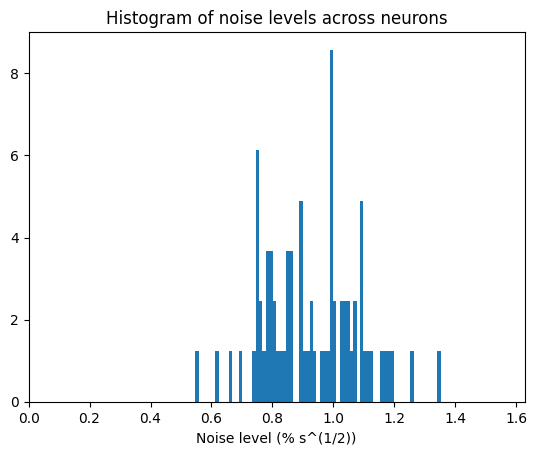

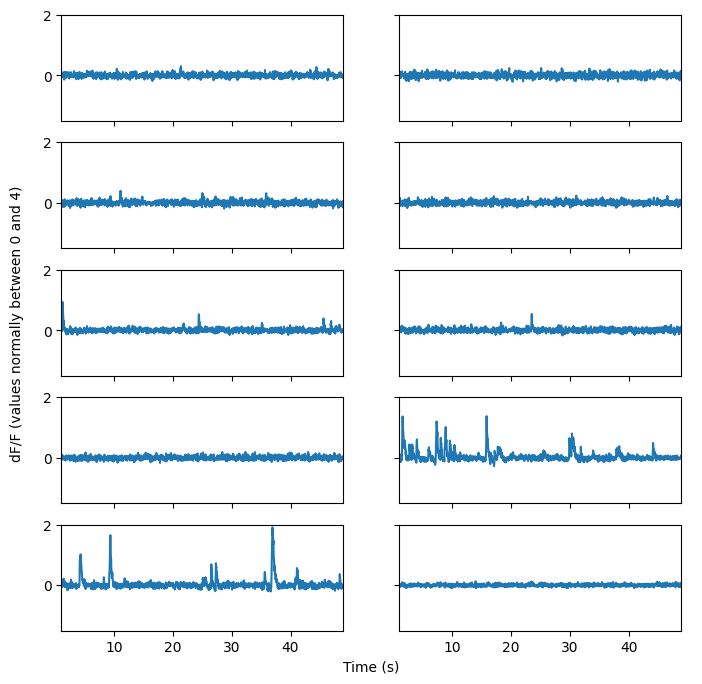

In [5]:
example_file = 'Example_datasets/Allen-Brain-Observatory-Visual-Coding-30Hz/Experiment_552195520_excerpt.mat'

traces = load_neurons_x_time( example_file )
frame_rate = 30


print('Number of neurons in dataset:', traces.shape[0])
print('Number of timepoints in dataset:', traces.shape[1])

# interactive plotting
%matplotlib inline

noise_levels = plot_noise_level_distribution(traces,frame_rate)

plt.rcParams['figure.figsize'] = (8.0, 8.0)
np.random.seed(3452)
neuron_indices = np.random.randint(traces.shape[0], size=10)
plot_dFF_traces(traces,neuron_indices,frame_rate)

## 3. Infer spike rates from calcium data 

### Get list of available models

In [6]:
cascade.download_model( 'update_models',verbose = 1)

yaml_file = open('Pretrained_models/available_models.yaml')
X = yaml.load(yaml_file)
list_of_models = list(X.keys())
print('\n List of available models: \n')
for model in list_of_models:
    print(model)

You can now check the updated available_models.yaml file for valid model names.
File location: d:\Cascade\Pretrained_models\available_models.yaml

 List of available models: 

Global_EXC_1Hz_smoothing500ms
Global_EXC_1Hz_smoothing1000ms
Zebrafish_1Hz_smoothing1000ms
Global_EXC_2Hz_smoothing300ms
Global_EXC_2Hz_smoothing500ms
Global_EXC_2Hz_smoothing1000ms
Global_EXC_2.5Hz_smoothing400ms_high_noise
Global_EXC_3Hz_smoothing400ms
Global_EXC_3Hz_smoothing400ms_high_noise
Global_EXC_3Hz_smoothing400ms_causalkernel
Global_EXC_4.25Hz_smoothing300ms
Global_EXC_4.25Hz_smoothing300ms_high_noise
Global_EXC_4.25Hz_smoothing300ms_causalkernel
Global_EXC_5Hz_smoothing200ms
Global_EXC_5Hz_smoothing200ms_causalkernel
Global_EXC_6Hz_smoothing200ms
Global_EXC_6Hz_smoothing200ms_causalkernel
Global_EXC_7Hz_smoothing200ms
Global_EXC_7Hz_smoothing200ms_causalkernel
Global_EXC_7.5Hz_smoothing200ms_high_noise
Global_EXC_7.5Hz_smoothing200ms
Global_EXC_7.5Hz_smoothing200ms_causalkernel
OGB_zf_pDp_7.5Hz_smooth

### Select and download pretrained model

In [27]:
model_name = 'Global_EXC_30Hz_smoothing25ms'

cascade.download_model( model_name,verbose = 1)

Pretrained model was saved in folder "d:\Cascade\Pretrained_models\Global_EXC_30Hz_smoothing25ms"


### Predict spike rates

In [28]:
spike_prob = cascade.predict( model_name, traces )


 
The selected model was trained on 18 datasets, with 5 ensembles for each noise level, at a sampling rate of 30Hz, with a resampled ground truth that was smoothed with a Gaussian kernel of a standard deviation of 25 milliseconds. 
 

Loaded model was trained at frame rate 30 Hz
Given argument traces contains 74 neurons and 6001 frames.
Noise levels (mean, std; in standard units): 0.93, 0.17

Predictions for noise level 2:
	... ensemble 0
434/434 [==============================] - 1s 1ms/step
	... ensemble 1
434/434 [==============================] - 0s 880us/step
	... ensemble 2
434/434 [==============================] - 0s 869us/step
	... ensemble 3
434/434 [==============================] - 0s 821us/step
	... ensemble 4
434/434 [==============================] - 0s 894us/step

Predictions for noise level 3:
	No neurons for this noise level

Predictions for noise level 4:
	No neurons for this noise level

Predictions for noise level 5:
	No neurons for this noise level

Predictions f

## 4. Save results to a data file

In [29]:
folder = os.path.dirname(example_file)
file_name = 'predictions_' + os.path.splitext( os.path.basename(example_file))[0]
save_path = os.path.join(folder, file_name)

# save as mat file
sio.savemat(save_path+'.mat', {'spike_prob':spike_prob})

# save as numpy file
np.save(save_path, spike_prob)

## 5. Plot the results together with calcium traces

array([0.00000000e+00, 3.33333333e-02, 6.66666667e-02, ...,
       4.99000000e+01, 4.99333333e+01, 4.99666667e+01])

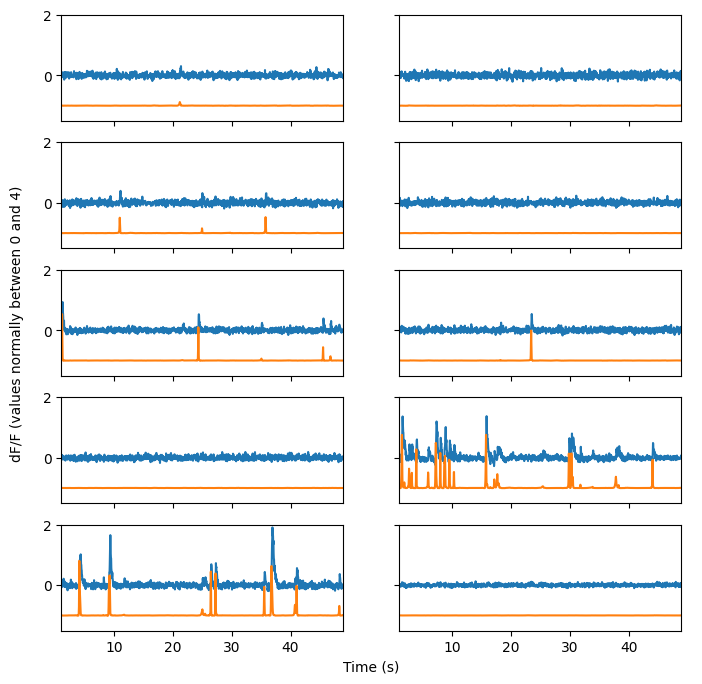

In [30]:
plt.rcParams['figure.figsize'] = (8.0, 8.0)
np.random.seed(3452)
neuron_indices = np.random.randint(traces.shape[0], size=10)
plot_dFF_traces(traces,neuron_indices,frame_rate,spike_prob)

## 6. Plot noise-matched calcium traces from the ground truth

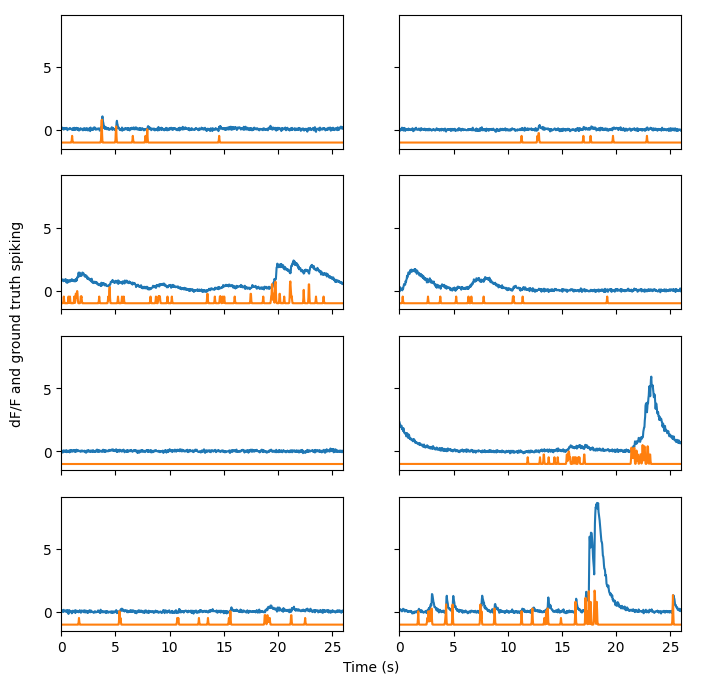

In [12]:
median_noise = np.round(np.median(noise_levels))
nb_traces = 8
duration = 26 # seconds
plot_noise_matched_ground_truth( model_name, median_noise, frame_rate, nb_traces, duration )

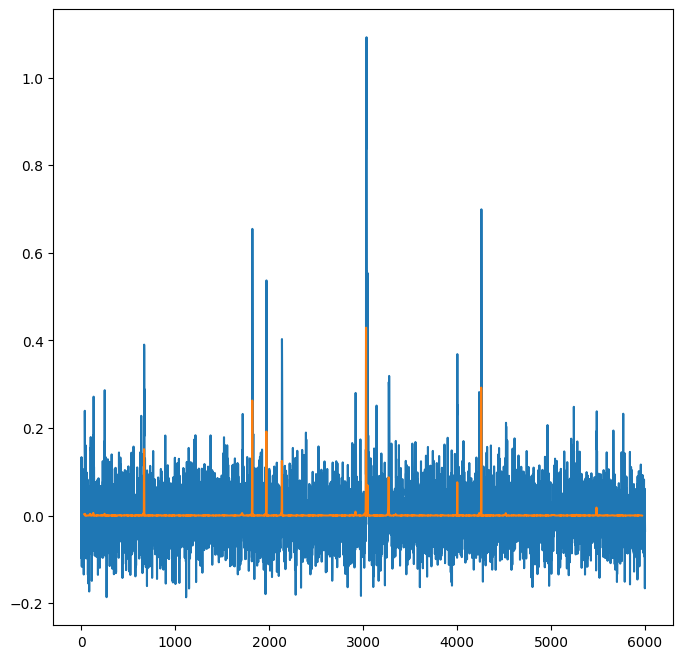

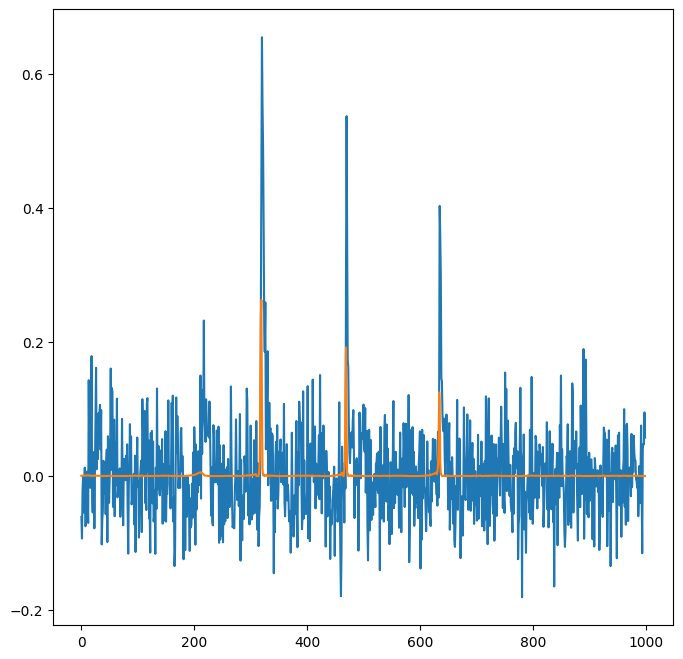

In [22]:
plt.figure()
plt.plot(traces[0])
plt.plot(spike_prob[0] * 0.2)
plt.show()

plt.figure()
plt.plot(traces[0, 1500:2500])
plt.plot(spike_prob[0, 1500:2500] * 0.2)
plt.show()